### AB Test

`Experimentation` has become a non-negotiable factor in keeping up with the dynamic nature of customers, helping to understand what works or doesnt work. 

The goal of experimentation is `learning.` Learning about customers, market segments, price sensitivity, choice, impact of specific features, the list is endless. AB Test is an interesting way to achieve the learning goal of experimentation.

##### What is an AB Test?

An AB Test simply means comparing two or multiple versions of an initiative backed up by a hypothesis (Which can be a new feature to your software program, modification to your website load-time speed, advertising copy, or evening your Call-to-Action button). If it impacts your KPIs then it should be tested.

An AB test always starts with an hypothesis. For example, you can propose that adding a new feature to your software program would increase the number of purchases that happen by users who visit your website. The truth is that you don't know if that holds true when the feature is eventually launched but that statement becomes your hypothesis, which you can then test with any experimentation method [An AB Test in this case].

For this short project, we go through a simple AB Test life-cyle for changes made to a webpage. We want to know if there is a significant change in conversion rate if we switch to a new webpage. Since we do not know the answer yet, we can run an AB Test to verify our hypothesis.

Our hypothesis - Changing our webpage will increase our conversion rate by `3%`.

Out hypothesis simply states that if we had a conversion rate on `15%` with the old page, launching our new page will increase this conversion rate to `18%`

#### Project Outline
1. Define business problem and Success metric
2. Hypotheses definition
3. Data importation and Preparation
4. Defining our Experiment Criteria
    - Statistical Power
    - Minimum Detectible Effect (MDE)
    - alpha
    - Confidence Interval
    - Sample Size
5. Running the experiment
6. Hypothesis testing
7. Decision Making


##### Business Problem
Arrowhead Inc is an E-commerce web platform with a variety of products and a wide range of customers. With a goal to improve the number of completed orders that they have [completed orders mean that the customer visited the website, bought a product and paid for it], they decide to redesign their product description page with some specific changes drawing the users' attention to the `Call-to-Action` button with an attractive colour.

The success of this change is not known beforehand and completely implementing this change only leaves fate to decide if it achieves the desired goal or not. We wouldn't want to waste resources and time before finding out that our initiative delivered the required result, rather we would test the new changes and compare the desired results with the existing web page design to know if we are on track with our goals, and that is the purpose of experimentation [AB Test in this use case].

##### Hypotheses
Null Hypothesis (H0) = Changing the outlook of our product description page will not increase our conversion rate by `3%` i.e. There is no significant difference between the old and new product page.

Alternative Hypothesis (H1) = Changing the outlook of our product description page will increase our conversion rate by `3%`i.e. A significant difference exists between the old and new product page.

The null hypothesis simply summarizes the point that if for example we have `100 customers` visiting our old web page and `15` of them end up buying the products, making changes to the web page will increase that number from `15` to `18` completed orders for every `100` customers that visit the new webpage.

Assuming that each customer spends and average of `$1,000`:
the old webpage generates `$15,000` monthly while the new webpage will generate $18,000 monthly, a `$3,000` increase

#### Data Importation and Preparation

In [12]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.stats.api as sms
import seaborn as sns
from math import ceil

%matplotlib inline
 

In [13]:
#Load Dataset
data = pd.read_csv(r"C:\Users\samue\OneDrive\Documents\Bobby\Datasets\AB Test\ab_data.csv")

In [14]:
data.rename(columns={'user_id':'user_id', 'timestamp':'timestamp', 'group':'experiment_group', 'landing_page':'product_page', 'converted':'converted'}, inplace=True)

data.head()


,user_id,timestamp,experiment_group,product_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


#### Dataset Features
- user_id - The unique identifier for each session. Every user has a unique identifier
- timestamp - When the session happened.
- group - The group which the user was assigned to for that specific session {control, treatment}
- landing_page - Tells us if the user saw either the old page or the new page during their session.
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

In [15]:
pd.crosstab(data['experiment_group'], data['product_page']) 

product_page,new_page,old_page
experiment_group,,
control,1928,145274
treatment,145311,1965


In [16]:
#Let's check if any user has more than two sessions in our dataset
session_counts = data['user_id'].value_counts(ascending=False)
print(session_counts)
multi_users = session_counts[session_counts > 1].count()
print(f'There are {multi_users} users that appear multiple times in the dataset')

user_id
805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: count, Length: 290584, dtype: int64
There are 3894 users that appear multiple times in the dataset


In [17]:
#Drop users with multiple sessions so no user is sampled twice
users_to_drop = session_counts[session_counts > 1].index
data = data[~data['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {data.shape[0]} entries')

The updated dataset now has 286690 entries


#### Experiment Design

##### Experiment Parameters
- Effect Size/Minimum Detectible Effect = `3%`
        *What does this mean?* The effect size simply lets us determine what size of difference we want to detect in our experiment. Do we want to oserve little or large differences? The smaller the difference you want to observe, the larger the sample size you will need. Increasing the sample size helps reduce the variance of the data so that even little changes are detectible whent he variance is significantly reduced.

- Statistical Power = `80%`
        *What does this mean?* The statistical power is the probability of detecting a difference between the conversion rate of the old page and the new page given that a difference exists in the first place. An increase dpower means that we want a higher chance of seeing a significant difference, hence we need a larger sample size.

- alpha =  `0.05`
        *What does this mean?* Alpha is a threshold of type-1 error (false positive) rate we are willing to allow in our experiment. If our p-value falls below alpha, it means that the chance of having an effect that is not really an effect is below `5%`

        The p-value is the probability of observing results equal to or more extreme than we have observed given that our null hypothesis is true. This means that if we observe differences between our old page and new page measured in conversion rate, the probability of observing such difference or differences greater than we have observed is very slim if truly the null hypothesis stands true, so we reject the null because the difference we have seen is unlikely if the null hypothesis was true.

- Comfidence level =  `95%`
        *What does this mean?* The confidence level tells us how much confidence we have in the process that creates our confidence interval estimates. i.e. How confident we are in the estimates we have predicted.
- Sample Size =  `2399` per group.
        The sample size is determined by other experimental parameters we have implemented. The number of users in our experiment is determined by several factors, including the `statistical power` and the `effect size` we want to observe.

In [18]:
#Calculating the effect size for out AB test experiment with the stats model package

effect_size = sms.proportion_effectsize(0.15,0.18)


In [31]:
#Calculating required sample size for our AB Test experiment
required_sample = sms.NormalIndPower().solve_power(
                                        effect_size,
                                        power = 0.8,
                                        alpha = 0.05,
                                        ratio = 1
                                                )

n = ceil(required_sample) #To the nearest whole number
print(f'We need {n} users for each group of our experiment')

We need 2399 users for each group of our experiment


Another way to determine our sample size is with a sample size calculator. Here we use the `StatSig` sample size calculator. See image attached.

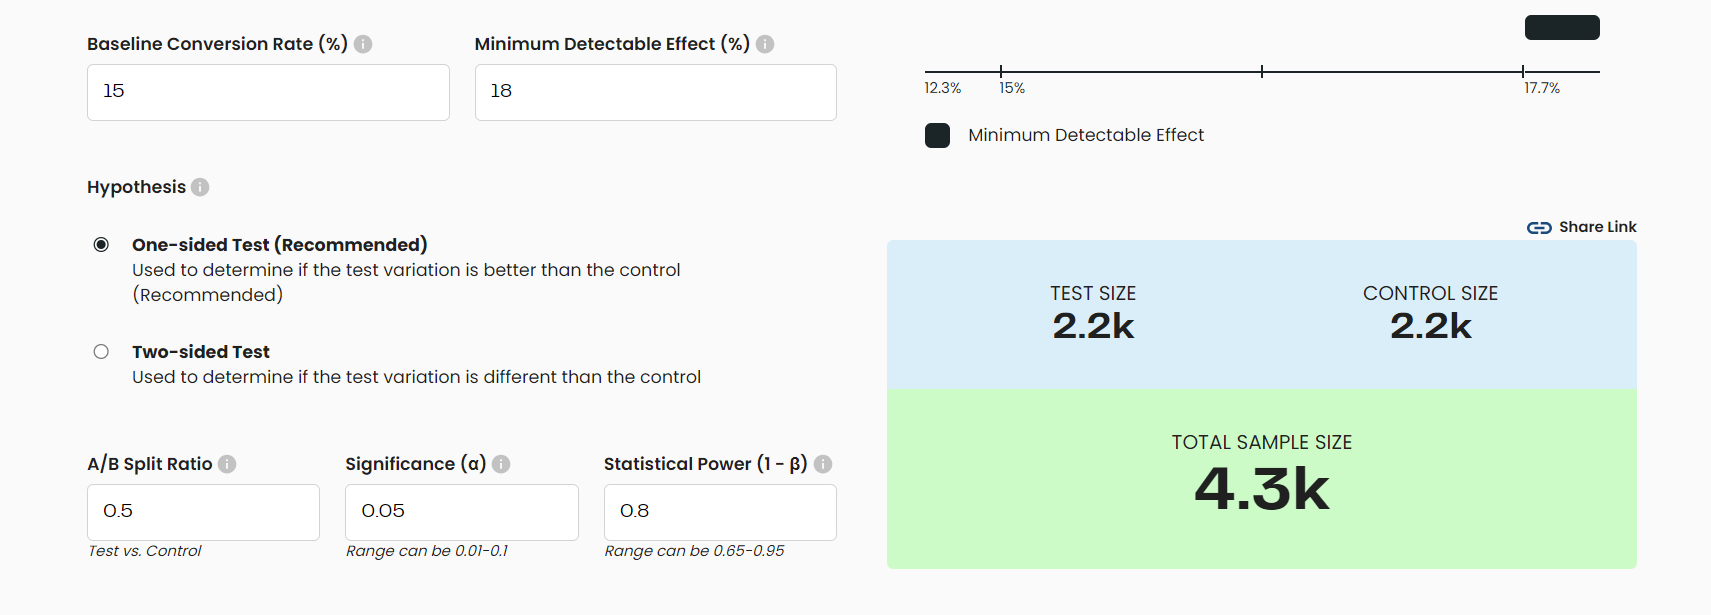

In [42]:
#using the results from our Scipy.stats sample size calculator
control_sample = data[data['experiment_group'] == 'control'].sample(n=n, random_state=1)
treatment_sample = data[data['experiment_group'] == 'treatment'].sample(n=n, random_state=1)

In [43]:
#combine both experiemnt groups into a single dataset
ab_test_data = pd.concat([control_sample, treatment_sample], axis=0)
ab_test_data.reset_index(drop=True, inplace=True)

ab_test_data

,user_id,timestamp,experiment_group,product_page,converted
0,788447,2017-01-15 10:15:53.966766,control,old_page,0
1,644367,2017-01-04 13:27:00.815306,control,old_page,0
2,921476,2017-01-13 11:28:38.186516,control,old_page,0
3,844813,2017-01-09 02:20:49.471715,control,old_page,0
4,675390,2017-01-09 23:51:06.765370,control,old_page,0
...,...,...,...,...,...
4793,929568,2017-01-19 18:47:40.217435,treatment,new_page,0
4794,763678,2017-01-09 05:25:23.842768,treatment,new_page,0
4795,764710,2017-01-16 03:57:53.708105,treatment,new_page,0
4796,632929,2017-01-23 08:25:23.672951,treatment,new_page,0


In [44]:
ab_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798 entries, 0 to 4797
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           4798 non-null   int64 
 1   timestamp         4798 non-null   object
 2   experiment_group  4798 non-null   object
 3   product_page      4798 non-null   object
 4   converted         4798 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 187.6+ KB


In [45]:
ab_test_data['experiment_group'].value_counts()

experiment_group
control      2399
treatment    2399
Name: count, dtype: int64

In [46]:
conversion_rates = ab_test_data.groupby('experiment_group')['converted']
ab_test_data.groupby('experiment_group')['converted'].mean()


experiment_group
control      0.122551
treatment    0.114631
Name: converted, dtype: float64

In [47]:
#Calculate basic statistical properties of our experiment data
std_dev = lambda x: np.std(x, ddof=0)
std_error = lambda x: stats.sem(x, ddof=0)

conversion_rates = conversion_rates.agg([np.mean, std_dev, std_error])
conversion_rates.columns = {'comversion_rate', 'standard_deviation', 'standard_error'}
conversion_rates.style.format('{:.3f}')

,comversion_rate,standard_deviation,standard_error
experiment_group,,,
control,0.123,0.328,0.007
treatment,0.115,0.319,0.007


#### Hypothesis testing

Test Method 1: `Proportions Z Test`

In [26]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [48]:
control_results = ab_test_data[ab_test_data['experiment_group'] == 'control']['converted']
treatment_results = ab_test_data[ab_test_data['experiment_group'] == 'treatment']['converted']

n_con = control_results.count()
n_treatment = treatment_results.count()

In [49]:
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treatment]

z_stats, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistics: {z_stats:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistics: 0.85
p-value: 0.396
ci 95% for control group: [0.109, 0.136]
ci 95% for treatment group: [0.102, 0.127]


Test Method 2: `Welch's T Test`

In [50]:
t_stats, t_p_val = stats.ttest_ind(control_results, treatment_results, equal_var = False)

In [51]:

print(f'z statistics: {t_stats:.2f}')
print(f'p-value: {t_p_val:.3f}')

z statistics: 0.85
p-value: 0.396


##### Decision Making

alpha = `0.05`

p-value = `0.396`

Since our p-value is greater than `alpha`, we cannot reject the Null Hypothesis. This means that the new product page did not generate the uplift in conversion rate as stated in our alternate hypothesis.


If we also examine the confidence interval *[which means that if we draw a sample from the population multiple times and construct a confidence interval each time, the confidence interval we have constructed will contain the true mean i.e true significant uplift value `95%` of the time]*, we can see that the confidence interval for our treatment group does not contain the expected lift in conversion that was expected. Our new oage performed worse than the okd product page.


##### What can be done here?
1. Validity checks to ensure that our experiment design was flawless and without bias
2. Run the experiment multiple times to see consistency of results.